# Infersent 

For this practicle we were instructed to implement 4 models as described in [1]. 

* Baseline: BoW model by averaging the word embeddings of the sentence.

* Uni-LSTM: An unidirectional LSTM model to encode the words in sequence into a fixed size representation. The last hidden state is used.

* Bi-LSTM: An bi directional LSTM model to encode the words in foward and backward sequence into a fixed size representaiton. The last hidden state is used.

* Bi-LSTM with Max pooling: Here callend Max-LSTM. A bi-directional LSTM model to encode the words in forward and backward sequence. Instead of the last hidden state, the max value of each dimension is used as representation.

Idealy the implementation should reproduce the results of the paper.

The word embeddings were taken from GloVe [2] 840B of 300 dimensions. The labeled data set used was the SNLI from Stanford [3].

[1] https://arxiv.org/abs/1705.02364

[2] https://nlp.stanford.edu/pubs/glove.pdf

[3] https://nlp.stanford.edu/pubs/snli_paper.pdf

The following cells contail _utils_ functions and the imports necessary for the rest of the notebook to work. 

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib as plt
import seaborn as sns
import infer 
from IPython.display import display
import PIL

%matplotlib inline

l_correction = 549367/9842 #train size/dev_size

In [2]:
def no_spaces(string):
    """replaces spaces by underscores of a string"""    
    string = string.split()
    string = "_".join(string)
    return string

def plot_n_save(df, title='', xlabel = 'Epochs', ylabel='Accuracy'):
    """make a nice looking plot and save it as png image.
    Input:
        df: (pd.DataFrame) containing the data organized in columns. Series will be ploted against the index of the 
            dataframe.
        title: (str) the title of the plot.
        xlabel, ylabel (str) the labels in the respective axis.
    Output:
        Display an pyplot image.
        Save an image using the title as name.
        """
    #set nice background and good size.
    sns.set(rc={'figure.figsize':(8,5)})
    
    #makes the plot
    ax = sns.lineplot(data = df)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    fig = ax.get_figure()
    
    #parse the title so to have no spaces
    title = no_spaces(title)
    
    #save image
    fig.savefig(title + ".png")

In [3]:
def parse_sts(sts_dict, sts_keys = ["STS12", "STS13", "STS14", "STS15", "STS16"]):
    """parse the STSXX results to make it easier to show them in a table.
    Input: 
        sts_dict (the dictionary format that comes out of the SentEval toolkit), must contain the sts_keys.
        sts_keys: (list(str)), list of keys with the STSXX results to be parsed.
    Output:
        dict(dict(float)) containing the parsed data. Ready to use in pd.DataFrame.from_dict()."""
    for k1 in sts_keys:
        for k2 in sts_dict[k1]:
            new_key = k1 +" "+ k2 
            if type(sts_dict[k1][k2]) == dict:
                d = {}
                for k3 in sts_dict[k1][k2]:
                    
                    #parses tuples
                    if (type(sts_dict[k1][k2][k3]) == tuple) | (type(sts_dict[k1][k2][k3]) == scipy.stats.stats.SpearmanrResult):
                        d[k3] = sts_dict[k1][k2][k3][0]
                        d[k3+'-p'] = sts_dict[k1][k2][k3][1]
                        
                    #parses dictionaries
                    elif (type(sts_dict[k1][k2][k3]) == dict):
                        for k4 in sts_dict[k1][k2][k3]:
                            if k4 == "mean":
                                d[k3] = sts_dict[k1][k2][k3][k4]
                            else:
                                d[k3 + " " + k4] = sts_dict[k1][k2][k3][k4]
                                
                #include parsed dict into the sts_dict
                sts_dict[new_key] = d
                
            else:   
                #treats edge cases
                sts_dict[new_key] = sts_dict[k1][k2]
                
        #delete key from dictionary
        sts_dict.pop(k1)
    return sts_dict

In [4]:
def display_row_images(list_im, title=None, save=False):
    """Display the Images in a row as ordered in list_im. 
    cotersy of: https://stackoverflow.com/a/30228789/4614404
    Input:
        list_im: (iterable(str)), an iterable containing the paths to the images and the images name with the 
            extension.
        title: (str), a title to be displayed above the image. It is also used as name to save the image.
        save: (bool), True to save image and False not to save it.
    Ouput:
        The images displayed in a row.
        If save, the images are saved into one single image.
    """
    #open all images
    imgs    = [ PIL.Image.open(i) for i in list_im ]
    
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

    #puts the arrays into an image again.
    imgs_comb = PIL.Image.fromarray( imgs_comb)
    
    if save:
        if not title:
            print("Cannot save image without a title")
        else:
            # save that beautiful picture
            imgs_comb.save(no_spaces(title)+".png")  
    
    if title:
        print(title)
        
    display(imgs_comb)

In [5]:
def gimme_image_list(path='./grad flow/', encoder='mean', entension='.png', max_epochs=20, num_images=5):
    """returns an list with image paths.
    Input:
        path: (str), folder path.
        encoder: (str), name of the encoder used. Options are 'mean', 'unilstm', 'bilstm' and 'maxlstm'.
        entension: (str), entension of the saved images. 
        max_epochs: (int), the number of saved images for the encoder. 
        num_images: (int), number of images in the outputed list.
    Ouput:
        list_im: (list(str)), list with the file names concatenated in the order: 
            path + encoder + epoch + entension
            len(list_im) = num_images.
            epochs: (list(int)), the epochs used for in list_m.
    """
    
    #loWeR case to avoid user issues.
    encoder = encoder.lower()
    
    #define the step
    num_images = num_images -1
    step = int(max_epochs/num_images)
    
    #select the epochs 
    epochs = [i for i in range(0, max_epochs+1, step)]
    
    #make a list with the the file names
    list_im = [path + encoder + str(i) + entension for i in epochs]
    
    return list_im, epochs

## Choice of Architecure

As to make the model modular and flexible and easy to extend, the model is made of an _encoder_ and of an _classifier_, they are specified in the files encoder.py and model.py respectively. The classifer, however, has to be used together with the encoder used to train it when in test time. This choice makes the model easy to be used in diferent contexts, only the classifier has to be called, and the encoder is then called in the forward pass of the classifier, away from the user.

After having the premise ( p ) and the hypothesis ( h ) encoded the classifier concatenates the vectors _\[p,h,|p-h|p*h\]_ before proceeding with the forward pass through the fully connected layers.

An example of how to call the model is given bellow:

``` prediction = model.forward((batch_of_premises, array_of_premise_lenghts),
                           (batch_of_hypothesis, array_of_hypothesis_lenghts)) ```
                       

## Baseline

The following regards the training evolution and the results in the SentEval tool kit by encoding sentences as the average of the word's embeddings.  


### Training evolution

The evolution of the training is shown in the following cells. 

It seems very odd that the accuracy on the training set is lower than the accuracy on the development set throughout the training process. For as far as I can tell, the examples in the development set are only being used for evaluation and the model does not learn from them. It is also cause of suspision the model's accuracy on the test set is higher than on the training and development set. The test set is only shown to the model in the end of the training process and is completelly untouched data until then. I could not find a plausible explanation nor flaw in the code that could lead to those results. There are two possibilities to explain the results:
* The model is somehow learning from dev and test examples in the training loop and what causes that could not be spoted.
* The examples in the dev and the test sets are on average easier to classify than the examples in the training set.

The final on test set is of accuracy of 61.2%.

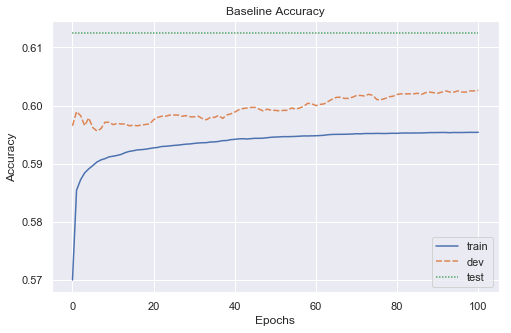

In [6]:
path = "./train/baseline/20190420/"

df_acc = pd.DataFrame(data = None, columns = ["train", "dev", "test"])
df_acc["train"] = np.load(path + "train_accmean.npy")
df_acc["dev"] = np.load(path + "dev_accmean.npy") 
df_acc["test"] = np.load(path + "test_accmean.npy")

plot_n_save(df = df_acc,
           title = "Baseline Accuracy",
           xlabel = "Epochs",
           ylabel = "Accuracy")

#stores results for later comparison
performance = {"Mean": [df_acc.iloc[-1]["train"], df_acc.iloc[-1]["dev"], df_acc.iloc[-1]["test"]]}

The loss curves show a similar trend as seen in the accuracy. However, the test loss is the highest, which was to be expected.

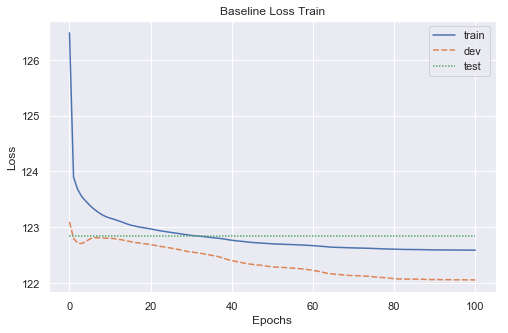

In [7]:
path = "./train/baseline/20190420/"

df_loss = pd.DataFrame(data = None, columns = ["train", "dev", "test"])
df_loss["train"] = np.load(path + "train_lossmean.npy")
df_loss["dev"] = np.load(path + "dev_lossmean.npy") * l_correction 
df_loss["test"] = np.load(path + "test_lossmean.npy") * l_correction

plot_n_save(df = df_loss,
           title = "Baseline Loss Train",
           xlabel = "Epochs",
           ylabel = "Loss")

#### Gradient Flow

To get an understading of how the model is learning across epochs I modified this function [4] to save the gradient flow at each epoch. In the image we see the max in light green and the average in blue of the gradient flow at each layer of the model.

Against my intuition, the gradient flow is not the strongest in the early epochs, but later in the training. The trend was the same across models. 

It is interesting to see that the layer closer to the input receives less gradient then the layer closer to the output, which is expected. 

[4] https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10

Gradient flow in epochs [0, 25, 50, 75, 100]


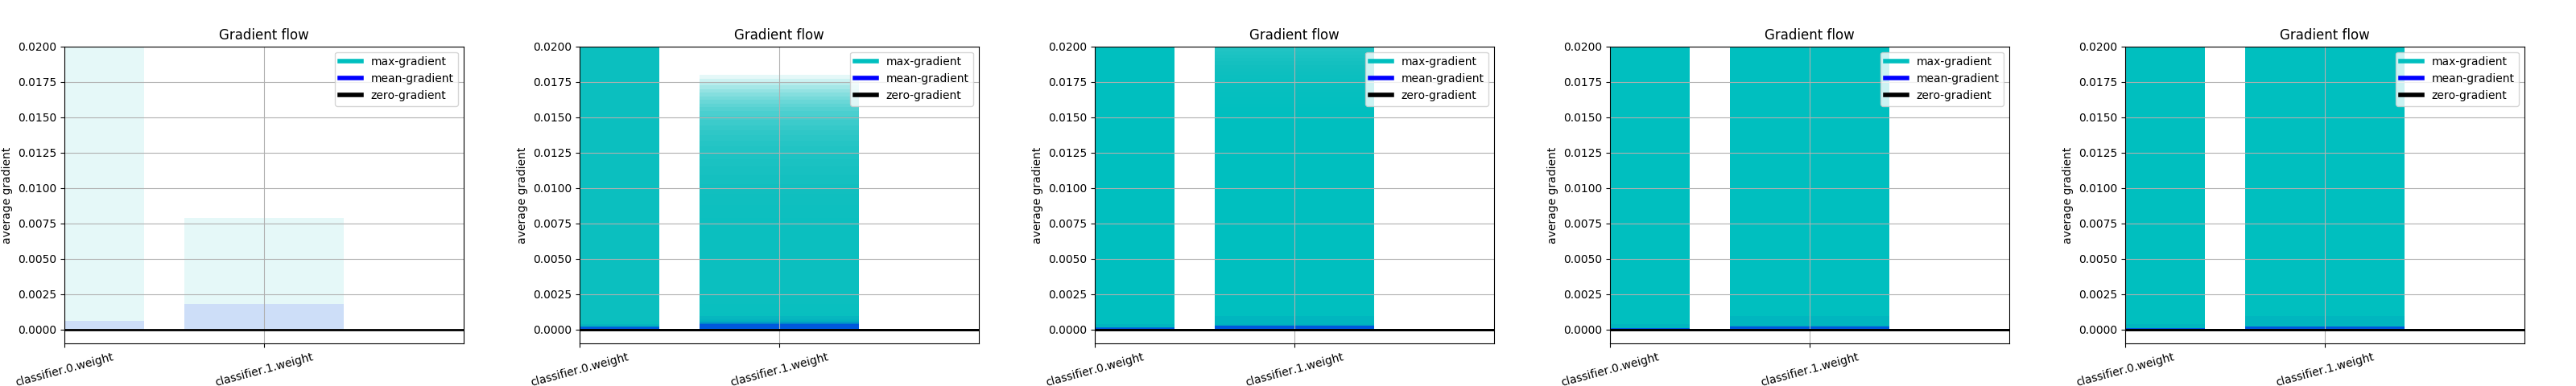

In [8]:
#display the gradient flow across epochs

#get list of images
list_im, epochs = gimme_image_list(path = './grad flow/mean/',
                                   encoder = 'mean',
                                   entension = '.png',
                                   max_epochs = 100, 
                                   num_images = 5)

#Make a nice looking title
title = "Gradient flow in epochs " + str(epochs)

#Dislplay all images.
display_row_images(list_im = list_im, 
                   title = title,
                   save = False)

### Transfer Learning

The model was used to encode sentences for other tasks by using the SentEval toolkit. The resultes encontered in the paper [1] were partially reproduced. All the results are shown in two tables in the cells below.

* Task: Courneaut et al. resutls ~ my results
* MR: 78.7 > 76.93
* CR: 78.5 ~ 78.36
* SUBJ: 91.6 ~ 91.18
* MPQA: 87.6 ~ 87.66
* SST: 79.8 ~ 79.68	
* TREC: 83.6 > 82.6
* MRPC: 72.1/80.9 < 73.16/81.69
* SICK R: 0.8 > 0.79
* SICK E: 78.6 < 78.69
* STS14: .54/.56 ~ 0.54/0.56

In [9]:
#load data
path = "./train/baseline/transfer/"
file = "transfer_task_all_mean.npy"

transfer_scores = np.load(path+file)
transfer_scores = transfer_scores[()]

tasks = list(transfer_scores.keys())
transfer_scores['Length']

#take the of STSXX, SSTX and SICK out of the dictionary for the sake of simplicity
problematic_keys = ["STS12", "STS13", "STS14", "STS15", "STS16", "STSBenchmark", "SICKRelatedness", "SST2", "SST5", ]
sts_dict = {}
for key in problematic_keys:
    sts_dict[key] = transfer_scores.pop(key)    

#make a table with the most comprehensible part of the results
df_transfer = pd.DataFrame.from_dict(transfer_scores, orient='index')
df_transfer

,devacc,acc,ndev,ntest,f1
BigramShift,50.35,50.01,10000,10000,NaN
CR,79.84,78.36,3775,3775,NaN
CoordinationInversion,53.61,53.60,10002,10002,NaN
Depth,30.85,30.16,10000,10000,NaN
Length,58.18,59.32,9996,9996,NaN
MPQA,87.43,87.66,10606,10606,NaN
MR,77.67,76.93,10662,10662,NaN
MRPC,73.55,73.16,4076,1725,81.69
ObjNumber,75.72,76.46,10000,10000,NaN
OddManOut,50.44,49.75,10000,10000,NaN


In [10]:
#parse the STSXX keys into an comprehensible dict
sts_dict = parse_sts(sts_dict)

#takes the mean of yhat, 
sts_dict['SICKRelatedness']['yhat'] = sts_dict['SICKRelatedness']['yhat'].mean()
sts_dict['STSBenchmark']['yhat'] = sts_dict['STSBenchmark']['yhat'].mean()

#make a table with the results missing in the df_transfer table
df_sts = pd.DataFrame.from_dict(sts_dict, orient='index')
df_sts

,devpearson,pearson,spearman,mse,yhat,ndev,ntest,devacc,acc,pearson-p,spearman-p,pearson wmean,spearman wmean
SICKRelatedness,0.797253,0.799244,0.718258,0.367680,3.536806,500.0,4927.0,NaN,NaN,NaN,NaN,NaN,NaN
SST2,NaN,NaN,NaN,NaN,NaN,872.0,1821.0,79.59,79.68,NaN,NaN,NaN,NaN
SST5,NaN,NaN,NaN,NaN,NaN,1101.0,2210.0,43.96,43.80,NaN,NaN,NaN,NaN
STS12 MSRpar,NaN,0.425039,0.451449,NaN,NaN,NaN,NaN,NaN,NaN,2.949501e-34,6.152520e-39,NaN,NaN
STS12 MSRvid,NaN,0.662090,0.675039,NaN,NaN,NaN,NaN,NaN,NaN,8.704721e-96,6.995979e-101,NaN,NaN
STS12 SMTeuroparl,NaN,0.491290,0.587659,NaN,NaN,NaN,NaN,NaN,NaN,2.916342e-29,5.754737e-44,NaN,NaN
STS12 all,NaN,0.522271,0.532783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531901,0.549506
STS12 surprise.OnWN,NaN,0.570257,0.610555,NaN,NaN,NaN,NaN,NaN,NaN,6.617653e-66,8.202285e-78,NaN,NaN
STS12 surprise.SMTnews,NaN,0.462677,0.339214,NaN,NaN,NaN,NaN,NaN,NaN,1.468185e-22,3.354224e-12,NaN,NaN
STS13 FNWN,NaN,0.382086,0.365692,NaN,NaN,NaN,NaN,NaN,NaN,5.788063e-08,2.285939e-07,NaN,NaN


## Uni LSTM

Unfortunatelly, I could not make the Uni-LSTM nor the Bi-LSTM work. I could not spot whatever is wrong in their logic, the Baseline and the Max-LSTM give ok results, they all share the same archtecture, which suggests that the problem is located in the forward pass of the Uni-LSTM, but I could not find a solution to make the encoder learn sentence representations.

The result below is similar for feeding the padded batch into the LSTM or by using the pack-padded sequence.

I started studing the gradient flow when to try to find the problem with the models, but, as shown below, there is gradient being back propagated. This sugests that something is fundametaly wrong with my implementation of the forward pass, however, my efforst were not sufficient to spot it.

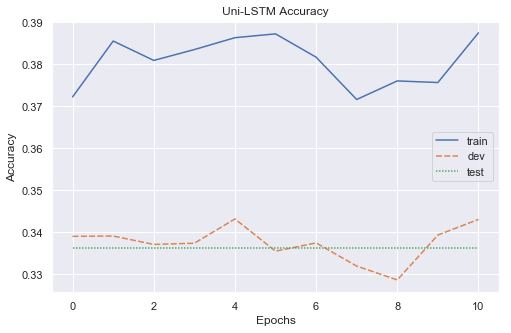

In [11]:
path = "./train/UniLSTM/20190422/"

df_acc = pd.DataFrame(data = None, columns = ["train", "dev", "test"])
df_acc["train"] = np.load(path + "train_accunilstm.npy")
df_acc["dev"] = np.load(path + "dev_accunilstm.npy") 
df_acc["test"] = np.load(path + "test_accunilstm.npy")

plot_n_save(df = df_acc,
           title = "Uni-LSTM Accuracy",
           xlabel = "Epochs",
           ylabel = "Accuracy")

#stores results for later comparison
performance["UniLSTM"] = [df_acc.iloc[-1]["train"], df_acc.iloc[-1]["dev"], df_acc.iloc[-1]["test"]]

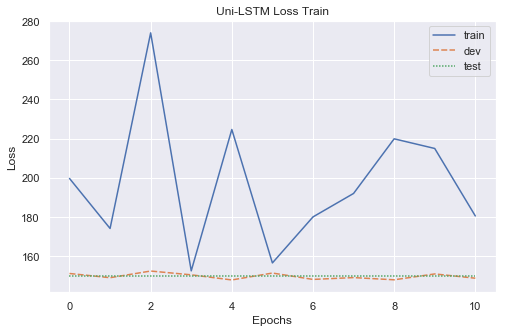

In [12]:
df_loss = pd.DataFrame(data = None, columns = ["train", "dev", "test"])
df_loss["train"] = np.load(path + "train_lossunilstm.npy")
df_loss["dev"] = np.load(path + "dev_lossunilstm.npy") * l_correction
df_loss["test"] = np.load(path + "test_lossunilstm.npy") * l_correction

plot_n_save(df = df_loss,
           title = "Uni-LSTM Loss Train",
           xlabel = "Epochs",
           ylabel = "Loss")

Gradient flow in epochs [0, 2, 4, 6, 8, 10]


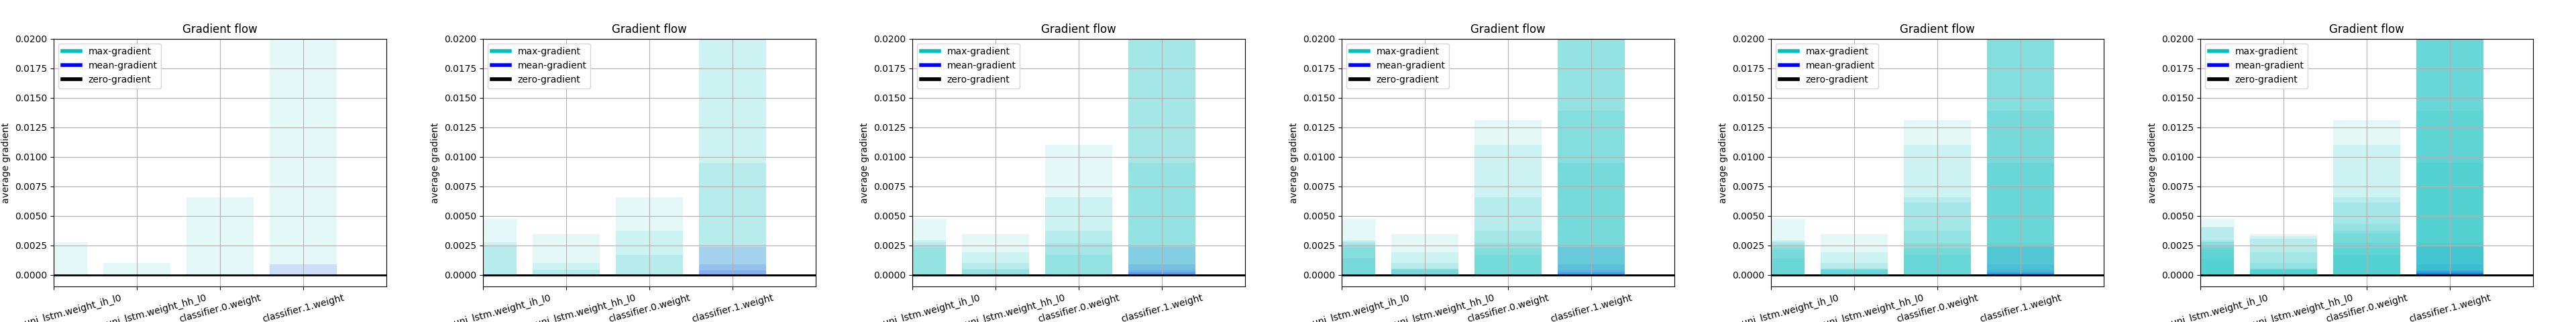

In [13]:
#display the gradient flow across epochs

#get list of images
list_im, epochs = gimme_image_list(path='./grad flow/unilstm/',
                                   encoder='unilstm',
                                   entension='.png',
                                   max_epochs=10, 
                                   num_images=5)

#Make a nice looking title
title = "Gradient flow in epochs " + str(epochs)

#Dislplay all images.
display_row_images(list_im = list_im, 
                   title = title,
                   save = False)

### Transfer Learning

As for the base line, the uni-LSTM was used encode sentences for other tasks by using the SentEval toolkit. All the results are shown in two tables in the cells below. The results, however, do not deserve much attention as the encoder fail to capture the semantics of the sentences in the training phase.

In [14]:
#load data
path = "./train/unilstm/transfer/"
file = "transfer_task_all_unilstm.npy"

transfer_scores = np.load(path+file)
transfer_scores = transfer_scores[()]

tasks = list(transfer_scores.keys())
transfer_scores['Length']

#take the of STSXX, SSTX and SICK out of the dictionary for the sake of simplicity
problematic_keys = ["STS12", "STS13", "STS14", "STS15", "STS16", "STSBenchmark", "SICKRelatedness", "SST2", "SST5", ]
sts_dict = {}
for key in problematic_keys:
    sts_dict[key] = transfer_scores.pop(key)    

#make a table with the most comprehensible part of the results
df_transfer = pd.DataFrame.from_dict(transfer_scores, orient='index')
df_transfer

,devacc,acc,ndev,ntest,f1
BigramShift,50.35,50.01,10000,10000,NaN
CR,79.84,78.36,3775,3775,NaN
CoordinationInversion,53.61,53.60,10002,10002,NaN
Depth,30.85,30.16,10000,10000,NaN
Length,58.18,59.32,9996,9996,NaN
MPQA,87.43,87.66,10606,10606,NaN
MR,77.67,76.93,10662,10662,NaN
MRPC,73.55,73.16,4076,1725,81.69
ObjNumber,75.72,76.46,10000,10000,NaN
OddManOut,50.44,49.75,10000,10000,NaN


In [15]:
#parse the STSXX keys into an comprehensible dict
sts_dict = parse_sts(sts_dict)

#takes the mean of yhat, 
sts_dict['SICKRelatedness']['yhat'] = sts_dict['SICKRelatedness']['yhat'].mean()
sts_dict['STSBenchmark']['yhat'] = sts_dict['STSBenchmark']['yhat'].mean()

#make a table with the results missing in the df_transfer table
df_sts = pd.DataFrame.from_dict(sts_dict, orient='index')
df_sts

,devpearson,pearson,spearman,mse,yhat,ndev,ntest,devacc,acc,pearson-p,spearman-p,pearson wmean,spearman wmean
SICKRelatedness,0.797253,0.799244,0.718258,0.367680,3.536806,500.0,4927.0,NaN,NaN,NaN,NaN,NaN,NaN
SST2,NaN,NaN,NaN,NaN,NaN,872.0,1821.0,79.59,79.68,NaN,NaN,NaN,NaN
SST5,NaN,NaN,NaN,NaN,NaN,1101.0,2210.0,43.96,43.80,NaN,NaN,NaN,NaN
STS12 MSRpar,NaN,0.425039,0.451449,NaN,NaN,NaN,NaN,NaN,NaN,2.949501e-34,6.152520e-39,NaN,NaN
STS12 MSRvid,NaN,0.662090,0.675039,NaN,NaN,NaN,NaN,NaN,NaN,8.704721e-96,6.995979e-101,NaN,NaN
STS12 SMTeuroparl,NaN,0.491290,0.588050,NaN,NaN,NaN,NaN,NaN,NaN,2.916342e-29,4.896945e-44,NaN,NaN
STS12 all,NaN,0.522271,0.532781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531901,0.549512
STS12 surprise.OnWN,NaN,0.570257,0.610555,NaN,NaN,NaN,NaN,NaN,NaN,6.617653e-66,8.202285e-78,NaN,NaN
STS12 surprise.SMTnews,NaN,0.462677,0.338812,NaN,NaN,NaN,NaN,NaN,NaN,1.468185e-22,3.569453e-12,NaN,NaN
STS13 FNWN,NaN,0.382086,0.365692,NaN,NaN,NaN,NaN,NaN,NaN,5.788063e-08,2.285939e-07,NaN,NaN


## Bi-LSTM

As for the Uni-LSTM, I could not make the Bi-LSTM work. 

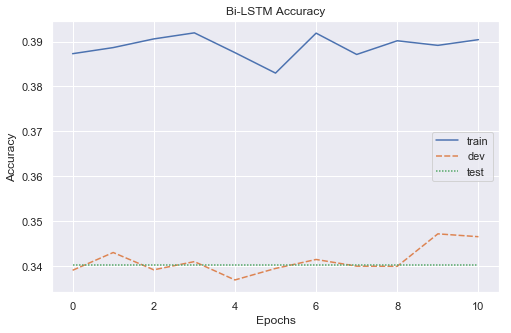

In [16]:
path = "./train/BiLSTM/20190422/"

df_acc = pd.DataFrame(data = None, columns = ["train", "dev", "test"])
df_acc["train"] = np.load(path + "train_accbilstm.npy")
df_acc["dev"] = np.load(path + "dev_accbilstm.npy") 
df_acc["test"] = np.load(path + "test_accbilstm.npy")

plot_n_save(df = df_acc,
           title = "Bi-LSTM Accuracy",
           xlabel = "Epochs",
           ylabel = "Accuracy")

#stores results for later comparison
performance["BiLSTM"] = [df_acc.iloc[-1]["train"], df_acc.iloc[-1]["dev"], df_acc.iloc[-1]["test"]]

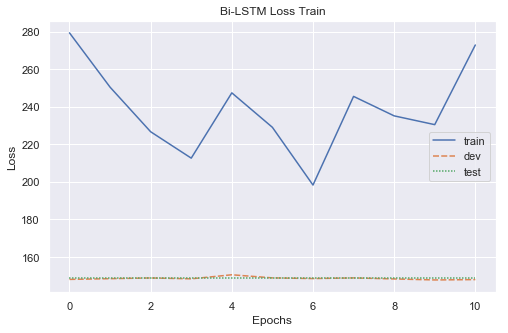

In [17]:
df_loss = pd.DataFrame(data = None, columns = ["train", "dev", "test"])
df_loss["train"] = np.load(path + "train_lossbilstm.npy")
df_loss["dev"] = np.load(path + "dev_lossbilstm.npy") * l_correction
df_loss["test"] = np.load(path + "test_lossbilstm.npy") * l_correction

plot_n_save(df = df_loss,
           title = "Bi-LSTM Loss Train",
           xlabel = "Epochs",
           ylabel = "Loss")

Gradient flow in epochs [0, 2, 4, 6, 8, 10]


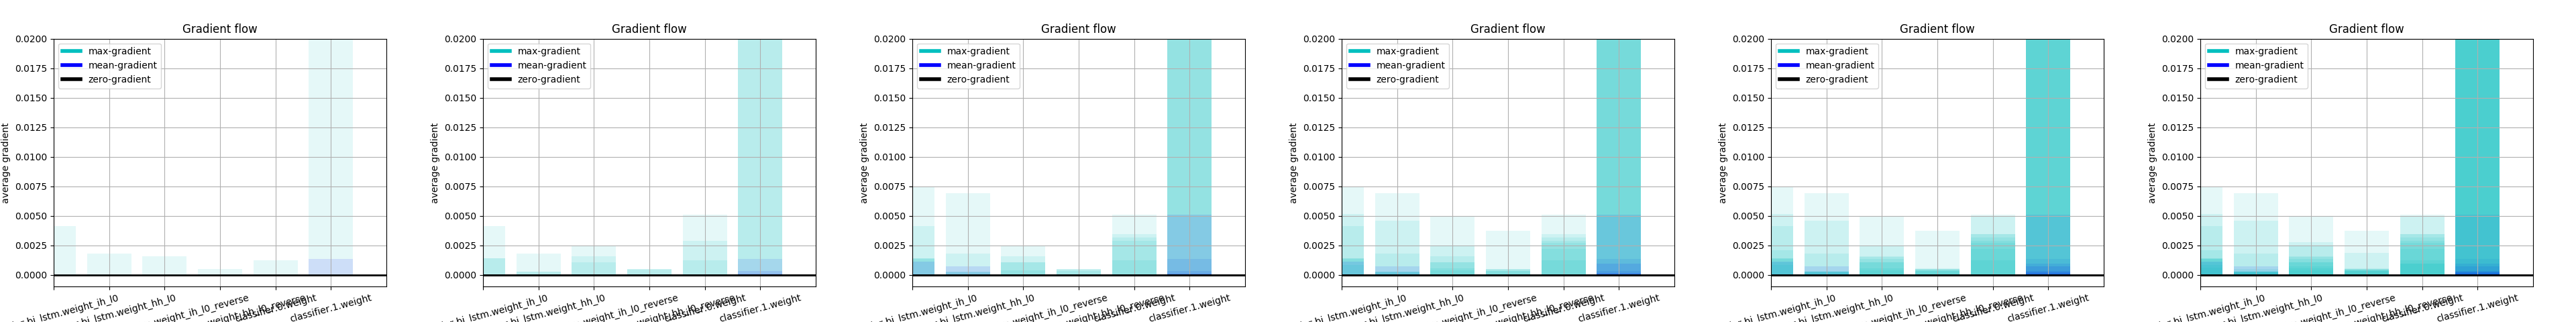

In [18]:
#display the gradient flow across epochs

#get list of images
list_im, epochs = gimme_image_list(path='./grad flow/bilstm/',
                                   encoder='bilstm',
                                   entension='.png',
                                   max_epochs=10, 
                                   num_images=5)

#Make a nice looking title
title = "Gradient flow in epochs " + str(epochs)

#Dislplay all images.
display_row_images(list_im = list_im, 
                   title = title,
                   save = False)

### Transfer Learning

As for the base line, the Bi-LSTM was used encode sentences for other tasks by using the SentEval toolkit. All the results are shown in two tables in the cells below. The results, however, do not deserve much attention as the encoder fail to capture the semantics of the sentences in the training phase.

In [ ]:
#load data
path = "./train/bilstm/transfer/"
file = "transfer_task_all_bilstm.npy"

transfer_scores = np.load(path+file)
transfer_scores = transfer_scores[()]

tasks = list(transfer_scores.keys())
transfer_scores['Length']

#take the of STSXX, SSTX and SICK out of the dictionary for the sake of simplicity
problematic_keys = ["STS12", "STS13", "STS14", "STS15", "STS16", "STSBenchmark", "SICKRelatedness", "SST2", "SST5", ]
sts_dict = {}
for key in problematic_keys:
    sts_dict[key] = transfer_scores.pop(key)    

#make a table with the most comprehensible part of the results
df_transfer = pd.DataFrame.from_dict(transfer_scores, orient='index')
df_transfer

,devacc,acc,ndev,ntest,f1
BigramShift,50.49,50.20,10000,10000,NaN
CR,79.09,78.54,3775,3775,NaN
CoordinationInversion,53.73,53.52,10002,10002,NaN
Depth,30.58,30.26,10000,10000,NaN
Length,58.81,59.53,9996,9996,NaN
MPQA,84.48,84.71,10606,10606,NaN
MR,74.78,74.71,10662,10662,NaN
MRPC,72.52,68.75,4076,1725,75.26
ObjNumber,74.23,75.40,10000,10000,NaN
OddManOut,50.78,50.35,10000,10000,NaN


In [ ]:
#parse the STSXX keys into an comprehensible dict
sts_dict = parse_sts(sts_dict)

#takes the mean of yhat, 
sts_dict['SICKRelatedness']['yhat'] = sts_dict['SICKRelatedness']['yhat'].mean()
sts_dict['STSBenchmark']['yhat'] = sts_dict['STSBenchmark']['yhat'].mean()

#make a table with the results missing in the df_transfer table
df_sts = pd.DataFrame.from_dict(sts_dict, orient='index')
df_sts

,devpearson,pearson,spearman,mse,yhat,ndev,ntest,devacc,acc,pearson-p,spearman-p,pearson wmean,spearman wmean
SICKRelatedness,0.790365,0.796891,0.714278,0.371666,3.540087,500.0,4927.0,NaN,NaN,NaN,NaN,NaN,NaN
SST2,NaN,NaN,NaN,NaN,NaN,872.0,1821.0,79.70,79.30,NaN,NaN,NaN,NaN
SST5,NaN,NaN,NaN,NaN,NaN,1101.0,2210.0,42.14,42.49,NaN,NaN,NaN,NaN
STS12 MSRpar,NaN,0.343938,0.370770,NaN,NaN,NaN,NaN,NaN,NaN,2.987567e-22,7.441823e-26,NaN,NaN
STS12 MSRvid,NaN,0.661899,0.674626,NaN,NaN,NaN,NaN,NaN,NaN,1.029762e-95,1.026564e-100,NaN,NaN
STS12 SMTeuroparl,NaN,-0.061971,0.406366,NaN,NaN,NaN,NaN,NaN,NaN,1.850611e-01,1.116145e-19,NaN,NaN
STS12 all,NaN,0.370296,0.467751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.409947,0.490938
STS12 surprise.OnWN,NaN,0.530039,0.573666,NaN,NaN,NaN,NaN,NaN,NaN,1.475823e-55,7.532288e-67,NaN,NaN
STS12 surprise.SMTnews,NaN,0.377574,0.313329,NaN,NaN,NaN,NaN,NaN,NaN,5.750595e-15,1.543759e-10,NaN,NaN
STS13 FNWN,NaN,0.371867,0.366239,NaN,NaN,NaN,NaN,NaN,NaN,1.374846e-07,2.186345e-07,NaN,NaN


## Max-LSTM

For the Max-LSTM I managed to get results in the same line as in the paper, however with lower accuracies. The final test accuracy is 74.8%.

### Training

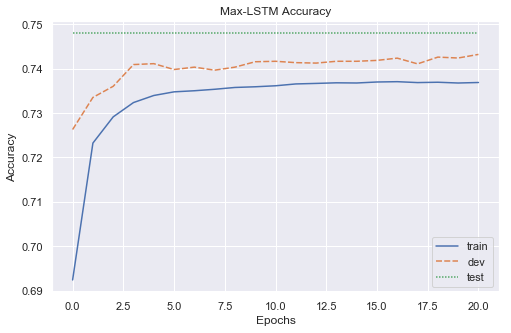

In [ ]:
path = "./train/MaxLSTM/20190421/"

df_acc = pd.DataFrame(data = None, columns = ["train", "dev", "test"])
df_acc["train"] = np.load(path + "train_accmaxlstm.npy")
df_acc["dev"] = np.load(path + "dev_accmaxlstm.npy") 
df_acc["test"] = np.load(path + "test_accmaxlstm.npy")

plot_n_save(df = df_acc,
           title = "Max-LSTM Accuracy",
           xlabel = "Epochs",
           ylabel = "Accuracy")

#stores results for later comparison
performance["MaxLSTM"] = [df_acc.iloc[-1]["train"], df_acc.iloc[-1]["dev"], df_acc.iloc[-1]["test"]]

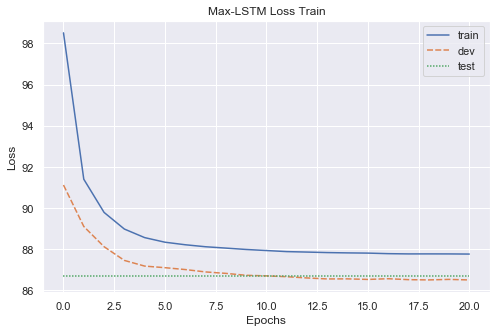

In [ ]:
path = "./train/MaxLSTM/20190421/"

df_loss = pd.DataFrame(data = None, columns = ["train", "dev", "test"])
df_loss["train"] = np.load(path + "train_lossmaxlstm.npy")
df_loss["dev"] = np.load(path + "dev_lossmaxlstm.npy") * l_correction
df_loss["test"] = np.load(path + "test_lossmaxlstm.npy") * l_correction

plot_n_save(df = df_loss,
           title = "Max-LSTM Loss Train",
           xlabel = "Epochs",
           ylabel = "Loss")

Gradient flow in epochs [0, 5, 10, 15, 20]


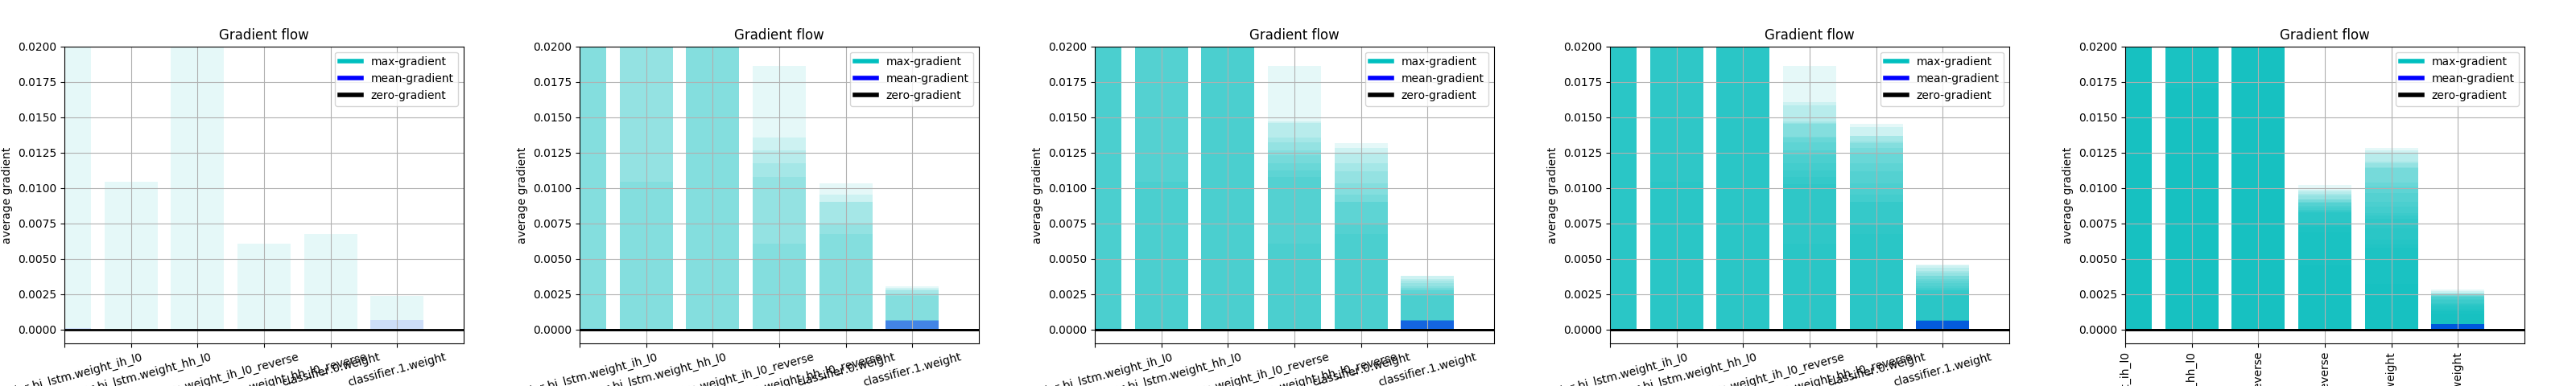

In [ ]:
#display the gradient flow across epochs

#get list of images
list_im, epochs = gimme_image_list(path='./grad flow/maxlstm/',
                                   encoder='maxlstm',
                                   entension='.png',
                                   max_epochs=20, 
                                   num_images=5)

#Make a nice looking title
title = "Gradient flow in epochs " + str(epochs)

#Dislplay all images.
display_row_images(list_im = list_im, 
                   title = title,
                   save = False)

### Transfer learning

As for the base line, the Max-LSTM was used encode sentences for other tasks by using the SentEval toolkit. The resultes encontered in the paper [1] were partially reproduced. All the results are shown in two tables in the cells below.

* Task: Courneaut et al. resutls ~ my results
* MR: 77.5 ~ 77.17
* CR: 81.3 > 78.22
* SUBJ: 89.6 < 91.08
* MPQA: 88.7 > 87.53
* SST: 80.7 ~ 79.79	
* TREC: 85.8 > 81.8
* MRPC: 73.2/81.6 < 73.04/82.09
* SICK R: 0.86 > 0.80
* SICK E: 83.4 < 78.81
* STS14: .39/.48 < 0.55/0.56

In [ ]:
#load data
path = "./train/MaxLSTM/transfer/"
file = "transfer_task_all_maxlstm.npy"

transfer_scores = np.load(path+file)
transfer_scores = transfer_scores[()] #trick to take the dict out of a zero-dim array.

#take the of STSXX, SSTX and SICK out of the dictionary for the sake of simplicity
problematic_keys = ["STS12", "STS13", "STS14", "STS15", "STS16", "STSBenchmark", "SICKRelatedness", "SST2", "SST5", ]
sts_dict = {}
for key in problematic_keys:
    sts_dict[key] = transfer_scores.pop(key)    

#make a table with the most comprehensible part of the results
df_transfer = pd.DataFrame.from_dict(transfer_scores, orient='index')
df_transfer

,devacc,acc,ndev,ntest,f1
BigramShift,50.40,50.04,10000,10000,NaN
CR,79.90,78.22,3775,3775,NaN
CoordinationInversion,53.61,53.48,10002,10002,NaN
Depth,30.68,29.92,10000,10000,NaN
Length,58.42,59.49,9996,9996,NaN
MPQA,87.45,87.53,10606,10606,NaN
MR,77.68,77.17,10662,10662,NaN
MRPC,73.50,73.04,4076,1725,82.09
ObjNumber,75.70,76.47,10000,10000,NaN
OddManOut,50.26,49.57,10000,10000,NaN


In [ ]:
#parse the STSXX keys into an comprehensible dict
sts_dict = parse_sts(sts_dict)

#takes the mean of yhat, 
sts_dict['SICKRelatedness']['yhat'] = sts_dict['SICKRelatedness']['yhat'].mean()
sts_dict['STSBenchmark']['yhat'] = sts_dict['STSBenchmark']['yhat'].mean()

#make a table with the results missing in the df_transfer table
df_sts = pd.DataFrame.from_dict(sts_dict, orient='index')
df_sts

,devpearson,pearson,spearman,mse,yhat,ndev,ntest,devacc,acc,pearson-p,spearman-p,pearson wmean,spearman wmean
SICKRelatedness,0.796940,0.799365,0.718504,0.367487,3.536771,500.0,4927.0,NaN,NaN,NaN,NaN,NaN,NaN
SST2,NaN,NaN,NaN,NaN,NaN,872.0,1821.0,79.36,79.79,NaN,NaN,NaN,NaN
SST5,NaN,NaN,NaN,NaN,NaN,1101.0,2210.0,43.78,43.80,NaN,NaN,NaN,NaN
STS12 MSRpar,NaN,0.425039,0.451449,NaN,NaN,NaN,NaN,NaN,NaN,2.949345e-34,6.152520e-39,NaN,NaN
STS12 MSRvid,NaN,0.662090,0.675038,NaN,NaN,NaN,NaN,NaN,NaN,8.704745e-96,7.002293e-101,NaN,NaN
STS12 SMTeuroparl,NaN,0.491290,0.587953,NaN,NaN,NaN,NaN,NaN,NaN,2.916275e-29,5.096888e-44,NaN,NaN
STS12 all,NaN,0.522271,0.532823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531902,0.549537
STS12 surprise.OnWN,NaN,0.570257,0.610555,NaN,NaN,NaN,NaN,NaN,NaN,6.617384e-66,8.202285e-78,NaN,NaN
STS12 surprise.SMTnews,NaN,0.462677,0.339118,NaN,NaN,NaN,NaN,NaN,NaN,1.468178e-22,3.404308e-12,NaN,NaN
STS13 FNWN,NaN,0.382086,0.365692,NaN,NaN,NaN,NaN,NaN,NaN,5.788041e-08,2.285939e-07,NaN,NaN


## SNLI summary

The table below sumarizes the results obtained in the SNLI task. Unfortunatelly, I was not able to implement working versions of the Uni-LSTM and Bi-LSTM models.

In [ ]:
df_performance = pd.DataFrame.from_dict(data = performance, 
                                        orient='index', 
                                        columns= ["Train acc", "Dev acc", "Test acc"])
df_performance

,Train acc,Dev acc,Test acc
Mean,0.595390,0.602622,0.612520
UniLSTM,0.387448,0.343060,0.336242
BiLSTM,0.390441,0.346510,0.340300
MaxLSTM,0.736884,0.743214,0.748072


## Inference bot

Bellow you will find a well humored implementation of infer.py. Infer loads one of the pretrained models, _MaxLSTM_ is the standard one. It is an interative aplication, the use is quite intuitive and straight forward. 

1. It asks for a premise. You should enter a phrase with the content. No special formatation is needed.
2. It asks for an hypothesis. You should enter the hypothesis. No special formatiation is needed.
3. It tells you if the premise entails, contradicts or is neutral to the hypothesis.
4. It asks if you want to enter a new premise. Press _n_ to quit or anything else to continue.

Note, the implementation requires the bot to load the word embeddings in memory. It takes a few minutes before it asks for the premise for the first time. Once loaded, all the rest workis timelly.

Have fun!

In [ ]:
infer.main()

['Loading GloVe...']
